In [1]:
import utils
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from astropy.io import ascii
from scipy import optimize
from matplotlib import mlab

In [2]:
df_data = utils.read_data("datasets/time-curves/2301590/")

In [3]:
df = df_data[['TIME','SAP_FLUX','PDCSAP_FLUX','SAP_FLUX_ERR','PDCSAP_FLUX_ERR','CADENCENO']].dropna()

In [4]:
col = ['SAP_FLUX','PDCSAP_FLUX']
ecol = ['SAP_FLUX_ERR','PDCSAP_FLUX_ERR']
col2 = ['F','FPDC']   # Names for the modified columns.
ecol2 = ['EF','EFPDC']

In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69302 entries, 0 to 3278
Data columns (total 21 columns):
TIME               66388 non-null float64
TIME_BJD           66388 non-null float64
TIMECORR           69302 non-null float64
CADENCENO          69302 non-null int64
SAP_FLUX           65434 non-null float64
SAP_FLUX_ERR       65434 non-null float64
SAP_BKG            65434 non-null float64
SAP_BKG_ERR        65434 non-null float64
PDCSAP_FLUX        64795 non-null float64
PDCSAP_FLUX_ERR    64795 non-null float64
SAP_QUALITY        69302 non-null int64
PSF_CENTR1         0 non-null float64
PSF_CENTR1_ERR     0 non-null float64
PSF_CENTR2         0 non-null float64
PSF_CENTR2_ERR     0 non-null float64
MOM_CENTR1         65434 non-null float64
MOM_CENTR1_ERR     65434 non-null float64
MOM_CENTR2         65434 non-null float64
MOM_CENTR2_ERR     65434 non-null float64
POS_CORR1          65646 non-null float64
POS_CORR2          65646 non-null float64
dtypes: float64(19), int64(2)


In [6]:
folder_path="datasets/time-curves/1026146/"
periods = []
freqs = []
filenames = os.listdir(folder_path)

for filename in filenames:
    if(filename.endswith('.tbl')):
        data = ascii.read(folder_path + filename).to_pandas()
        #utils.remove_noise(data,data.PDCSAP_FLUX)
        data = data[['TIME','SAP_FLUX','PDCSAP_FLUX','SAP_FLUX_ERR','PDCSAP_FLUX_ERR','CADENCENO']].dropna()
        res = utils.fit_sin(data.TIME, data.PDCSAP_FLUX)
        periods = np.append(periods, res["period"])
        freqs = np.append(freqs,res["freq"])
        #utils.plot_data(data.TIME, data.MEDIAN)

In [7]:
periods

array([ 14.05539634,  14.49689653,  12.08705823,   7.51096332,
        16.62774742,  14.78387519,  15.43706606,  14.81196516,
        14.92887303,  12.00446511,  14.14084284,  14.55770408,
        12.27967071,  14.32406868,  15.75880453,   7.24910849,  19.49454336])

In [8]:
np.median(periods)

14.496896528305214

In [9]:
np.std(periods)

2.8968408051573067

In [10]:
periods

array([ 14.05539634,  14.49689653,  12.08705823,   7.51096332,
        16.62774742,  14.78387519,  15.43706606,  14.81196516,
        14.92887303,  12.00446511,  14.14084284,  14.55770408,
        12.27967071,  14.32406868,  15.75880453,   7.24910849,  19.49454336])

In [11]:
freq = max(freqs)

In [12]:
freq

0.13794799752902537

In [13]:
import P4J

In [14]:
my_per = P4J.periodogram(method='PDM1')

In [15]:
res

{'amp': -21.91190407927445,
 'omega': 0.32230482089416446,
 'phase': -35.787266141479542,
 'offset': 10019.944453968663,
 'freq': 0.051296405427654262,
 'period': 19.494543363478893,
 'fitfunc': <function utils.fit_sin.<locals>.<lambda>(t)>,
 'maxcov': 0.94327201537240202,
 'rawres': (array([  6.46304636e+01,   2.24564281e-01,   0.00000000e+00,
           1.00203777e+04]),
  array([ -2.19119041e+01,   3.22304821e-01,  -3.57872661e+01,
           1.00199445e+04]),
  array([[  9.43272015e-01,  -4.80753846e-05,   1.86084275e-02,
            1.77014595e-02],
         [ -4.80753846e-05,   2.55956321e-06,  -1.01555960e-03,
            7.08724068e-05],
         [  1.86084275e-02,  -1.01555960e-03,   4.04766272e-01,
           -2.97365277e-02],
         [  1.77014595e-02,   7.08724068e-05,  -2.97365277e-02,
            4.56461996e-01]]))}

In [16]:
my_per.set_data(mjd=np.array(data.TIME), mag=np.array(data.PDCSAP_FLUX), err=np.array(data.PDCSAP_FLUX_ERR))

In [17]:
my_per.frequency_grid_evaluation(fmin=0.0, fmax=freq, fresolution=1e-5)  # frequency sweep parameters

In [18]:
my_per.finetune_best_frequencies(fresolution=1e-5, n_local_optima=10)

In [19]:
freq, per = my_per.get_periodogram()

In [20]:
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies

In [21]:
pbest

array([-0.01718907, -0.01726631, -0.01727099, -0.01728495, -0.01728773,
       -0.01729306, -0.01731925, -0.01733979, -0.01736019, -0.01737   ], dtype=float32)

In [22]:
from pwkit.pdm import pdm

In [26]:
results = pdm(np.array(data.TIME),np.array(data.PDCSAP_FLUX),np.array(data.PDCSAP_FLUX_ERR),periods,20)

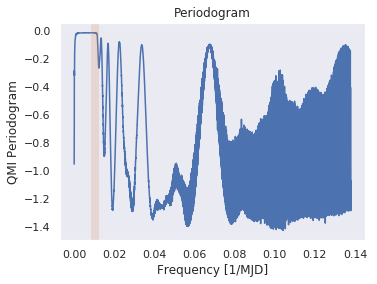

In [25]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('QMI Periodogram')
plt.title('Periodogram')
plt.grid()

In [27]:
results.pmin

14.811965163750996

In [55]:
r = copy.deepcopy(data)

In [56]:
for c,ec,c2,ec2 in zip(col,ecol,col2,ecol2):
    medf = np.median(r[c])
    norm = r[c] / medf - 1
    enorm = r[ec] / medf
    r[c2] = norm
    r[ec2] = enorm

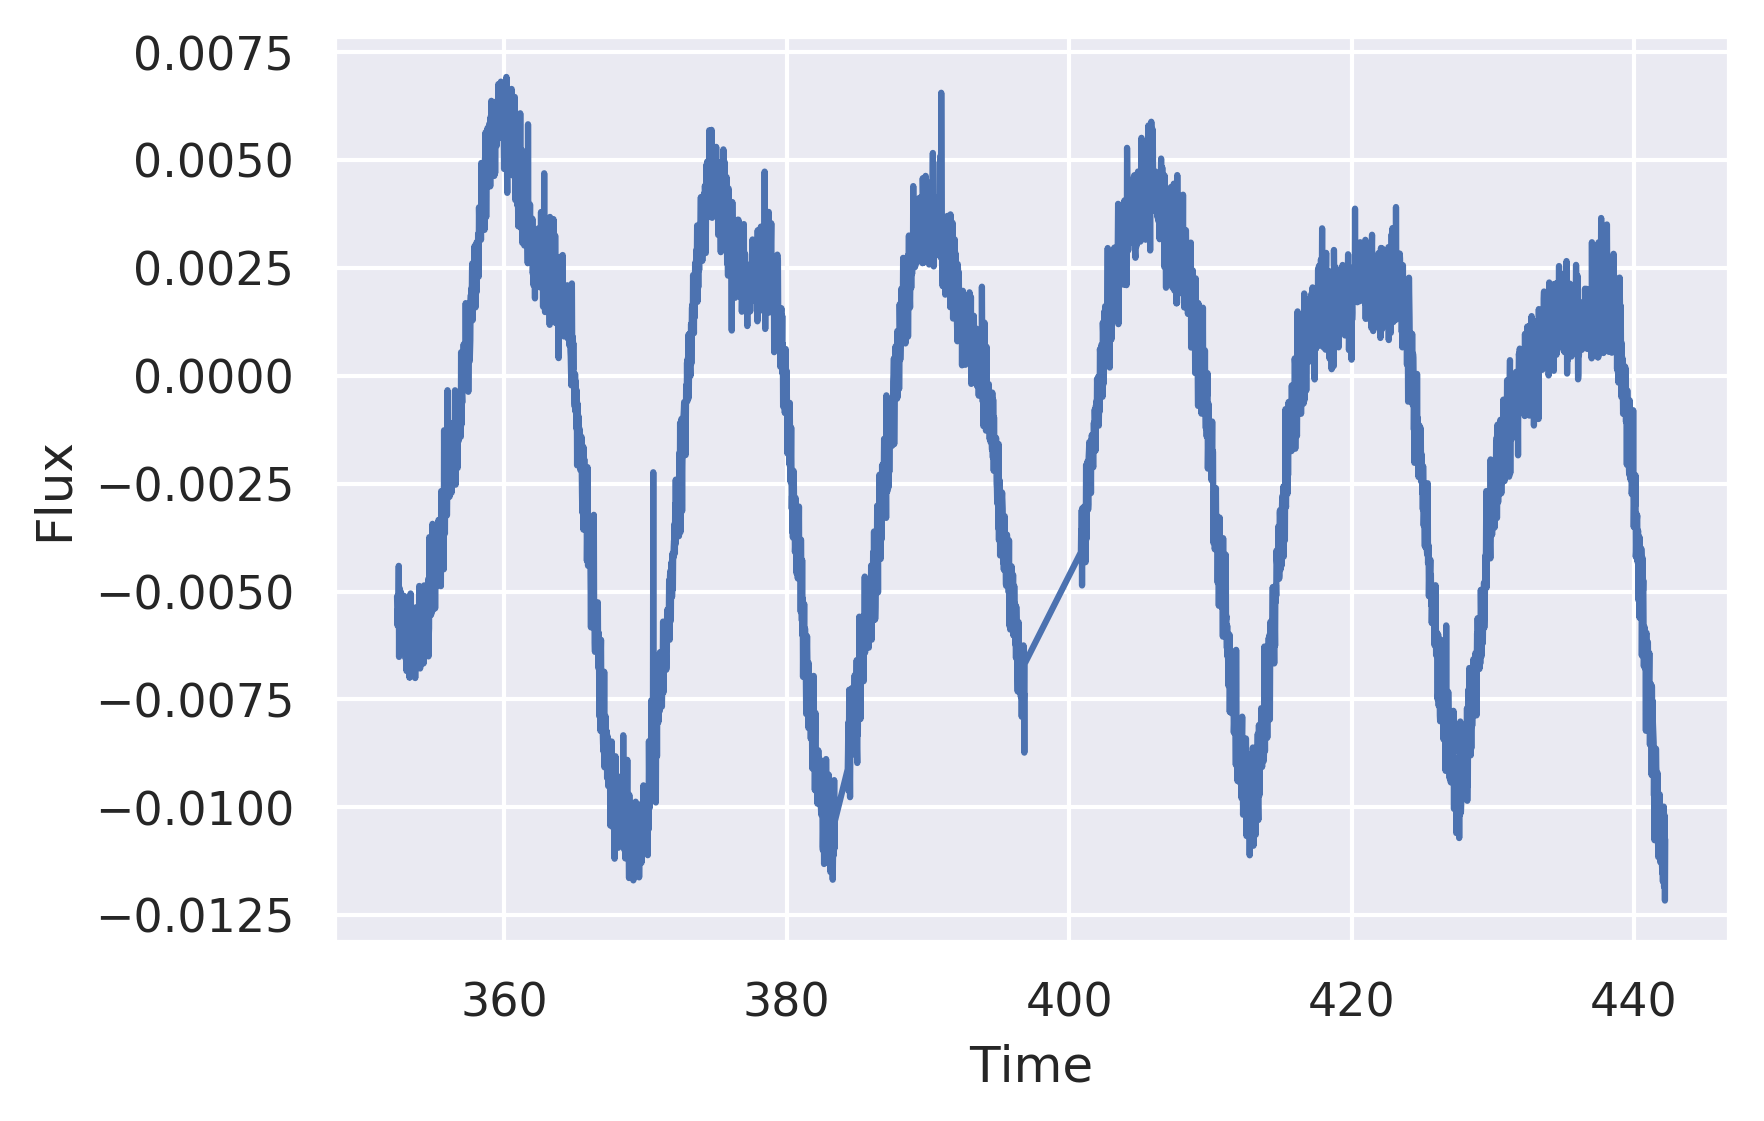

In [57]:
utils.plot_data(r.TIME,r.FPDC)

In [58]:
utils.remove_noise(df=r,data=r.FPDC)

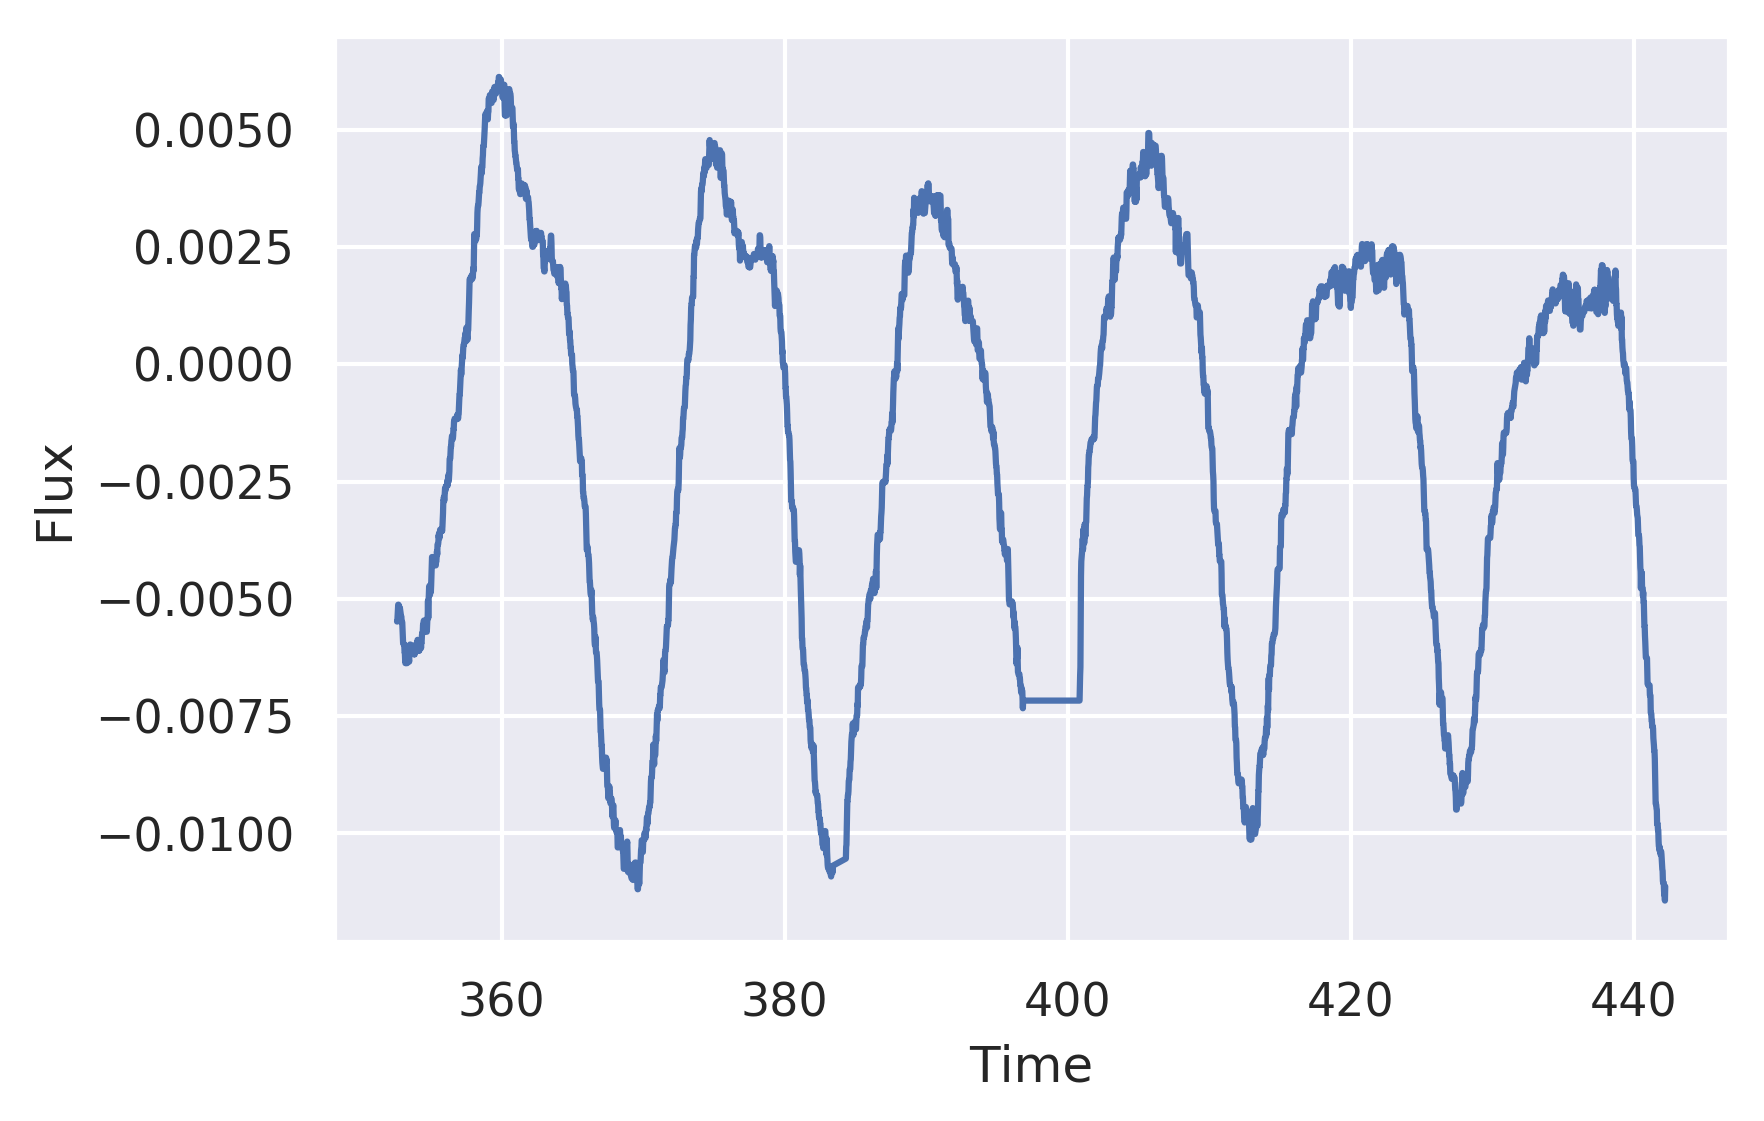

In [59]:
utils.plot_data(r.TIME,r.MEDIAN)

In [61]:
r = r.dropna()

In [63]:
res = utils.fit_sin(r.TIME, r.MEDIAN)

In [64]:
res["period"]

14.875260247029296

In [66]:
folder_path="datasets/time-curves/1026146/"
periods = []
freqs = []
filenames = os.listdir(folder_path)

for filename in filenames:
    if(filename.endswith('.tbl')):
        data = ascii.read(folder_path + filename).to_pandas()
        data = data[['TIME','SAP_FLUX','PDCSAP_FLUX','SAP_FLUX_ERR','PDCSAP_FLUX_ERR','CADENCENO']].dropna()
        r = copy.deepcopy(data)
        for c,ec,c2,ec2 in zip(col,ecol,col2,ecol2):
            medf = np.median(r[c])
            norm = r[c] / medf - 1
            enorm = r[ec] / medf
            r[c2] = norm
            r[ec2] = enorm
        utils.remove_noise(r, r.FPDC)        
        r = r.dropna()
        res = utils.fit_sin(r.TIME, r.MEDIAN)
        periods = np.append(periods, res["period"])
        freqs = np.append(freqs,res["freq"])
        #utils.plot_data(data.TIME, data.MEDIAN)

In [76]:
freq = max(freqs)

In [67]:
periods

array([ 14.04943825,  14.50160236,  14.66981219,   7.50601505,
        16.66746922,  14.79083994,  15.44228232,  14.81640845,
        14.92494678,  11.99405821,  14.15057465,  14.5427481 ,
        12.27261591,  14.33089032,  15.75569312,   7.25450551,  14.87526025])

In [85]:
np.median(periods)

14.542748096301647

In [88]:
results = pdm(np.array(r.TIME),np.array(r.MEDIAN),np.array(r.EFPDC),periods,20)

In [87]:
results

PDMResult(thetas=array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan]), imin=0, pmin=14.049438245030071, mc_tmins=array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  